# Projected economic damages from the upcoming El Niño event
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
from scipy import stats, signal
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.lines import Line2D

Data locations

In [2]:
loc_pwt = "../Data/PWT/"
loc_coefs = "../Data/RegressionResults/"
loc_panel = "../Data/Panel/"
loc_enso = "../Data/ENSO_Indices/"
loc_forecast = "../Data/Forecast/"
loc_wdi = "../Data/WDI/upto2021/"
loc_out = "../Data/Historical_Damages/"
loc_summary = "../Data/SummaryData/"

Read projected Niño3.4 index

In [3]:
#forecast = pd.read_csv(loc_forecast+"IRI_ENSO_Forecasts_05042023.csv")
forecast = pd.read_csv(loc_forecast+"IRI_ENSO_Forecasts_06222023.csv")

Plot forecast

In [4]:
models = forecast.Model.values
months = forecast.columns[2:].values

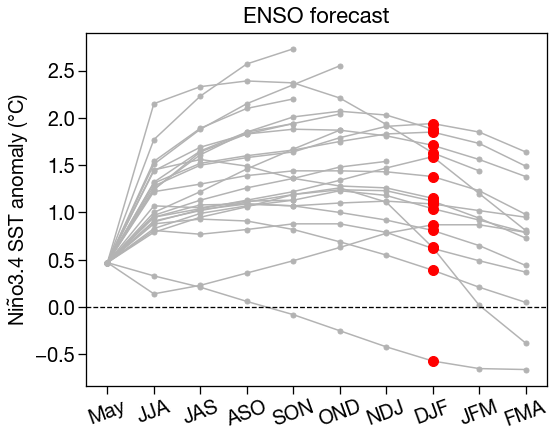

In [6]:
fig = plt.figure(figsize=(9,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"


gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.11,right=0.82,top=0.85,bottom=0.15,wspace=0.27,hspace=0.28)

tfs = 22
lfs = 18

ax = plt.subplot(gs1[0,0])

for m in models:
    #model_forecast = np.concatenate([[0],forecast.iloc[models==m,2:].values[0]])
    model_forecast = forecast.iloc[models==m,2:].values[0]
    plt.plot(np.arange(0,len(model_forecast),1),model_forecast,
            color=[0.7,0.7,0.7],marker="o",markersize=5,zorder=1)
    
djf_vals = forecast.loc[:,"DJF"].values
for x in djf_vals:
    if ~np.isnan(x):
        plt.scatter(list(months).index("DJF"),x,color="red",s=100,zorder=2)
    
    
plt.title("ENSO forecast",fontsize=tfs,pad=10)
plt.ylabel("Ni$\~n$o3.4 SST anomaly ($\degree$C)")

plt.axhline(y=0,color="black",linewidth=1.3,linestyle="--")

months[0] = "May"
plt.xticks(ticks=np.arange(0,9+1,1),labels=months,rotation=20)

plt.show()

Now read Niño3.4 regression coefficients

In [7]:
phase = "ENSO"
enso_var = "nino34"
nlag = 5
trend = "none"
response_var = "gr_pwt_frac"
enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response_var+"_trend"+trend+".csv",index_col=0)
int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response_var+"_trend"+trend+".csv",index_col=0)
boot = enso_coefs.boot.values
nboot = len(boot)

Assemble into xarray dataarrays

In [8]:
lags = np.arange(0,nlag+1,1)
coefs_enso_xr = xr.DataArray(enso_coefs.iloc[:,1:].values,
                            coords=[boot,lags],dims=["boot","lag"])
coefs_int_xr = xr.DataArray(int_coefs.iloc[:,1:].values,
                            coords=[boot,lags],dims=["boot","lag"])

In [9]:
np.mean(enso_coefs.iloc[:,2:].sum(axis=1))

0.009818328224681828

In [10]:
np.mean(int_coefs.iloc[:,2:].sum(axis=1))

-0.02877329528830107

In [11]:
np.mean(enso_coefs.iloc[:,2:].sum(axis=1)) + np.mean(int_coefs.iloc[:,2:].sum(axis=1))

-0.018954967063619245

Use panel dataset to assemble country-by-time arrays over the timescale of the assumed growth extension

In [12]:
y1_panel = 1960
y2_panel = 2019
panel = pd.read_csv(loc_panel+"ENSO_Growth_Panel_"+str(y1_panel)+"-"+str(y2_panel)+".csv",index_col=0)
iso = np.unique(panel.iso.values)

In [13]:
y1_extended = 2014
y2_extended = 2029
y1_gr = 2015
y2_gr = 2019
time_ext = np.arange(y1_extended,y2_extended+1,1)

In [14]:
gpc = xr.DataArray(np.full((len(iso),len(time_ext)),np.nan),
                     coords=[iso,time_ext],dims=["iso","time"])
population = xr.DataArray(np.full((len(iso),len(time_ext)),np.nan),
                     coords=[iso,time_ext],dims=["iso","time"])

for jj in np.arange(0,len(iso),1):
    i = iso[jj]
    gpc.loc[i,2014:2019] = panel.loc[(panel.iso==i)&(panel.year>=2014)&(panel.year<=2019),"gpc_pwt"].values
    population.loc[i,2014:2019] = panel.loc[(panel.iso==i)&(panel.year>=2014)&(panel.year<=2019),"pop_pwt"].values

Calculate growth

In [15]:
gpc_growth = gpc.diff(dim="time",n=1)/(gpc.loc[:,:(y2_extended-1)].values)
pop_growth = population.diff(dim="time",n=1)/(population.loc[:,:(y2_extended-1)].values)

Load WDI data

In [16]:
wdi_gpc = pd.read_csv(loc_wdi+"API_NY.GDP.PCAP.KD_DS2_en_csv_v2_5358375.csv") # this is constant 2015 dollars but we just want growth (not levels) so it doesnt matter
wdi_pop = pd.read_csv(loc_wdi+"API_SP.POP.TOTL_DS2_en_csv_v2_5436324.csv")

Now add 2020 and 2021 growth rates from WDI

In [17]:
for i in gpc_growth.iso.values:
    if i in wdi_gpc["Country Code"].values:
        gpc_2019 = wdi_gpc.loc[wdi_gpc["Country Code"]==i,"2019"].values[0]
        gpc_2020 = wdi_gpc.loc[wdi_gpc["Country Code"]==i,"2020"].values[0]
        gpc_2021 = wdi_gpc.loc[wdi_gpc["Country Code"]==i,"2021"].values[0]
        gpc_growth.loc[i,2020] = (gpc_2020-gpc_2019)/gpc_2019
        gpc_growth.loc[i,2021] = (gpc_2021-gpc_2020)/gpc_2020
        
    if i in wdi_pop["Country Code"].values:
        pop_2019 = wdi_pop.loc[wdi_pop["Country Code"]==i,"2019"].values[0]
        pop_2020 = wdi_pop.loc[wdi_pop["Country Code"]==i,"2020"].values[0]
        pop_2021 = wdi_pop.loc[wdi_pop["Country Code"]==i,"2021"].values[0]
        pop_growth.loc[i,2020] = (pop_2020-pop_2019)/pop_2019
        pop_growth.loc[i,2021] = (pop_2021-pop_2020)/pop_2020

Now add growth for 2022 and beyond

In [18]:
for i in gpc_growth.iso.values:
    gpc_growth.loc[i,2022:] = gpc_growth.loc[i,y1_gr:y2_gr].mean(dim="time")
for i in pop_growth.iso.values:
    pop_growth.loc[i,2022:] = pop_growth.loc[i,y1_gr:y2_gr].mean(dim="time")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Now infer GPC and population

In [19]:
for y in np.arange(2020,y2_extended+1,1):
    gpc.loc[:,y] = gpc.loc[:,y-1] + (gpc.loc[:,y-1]*gpc_growth.loc[:,y])
    population.loc[:,y] = population.loc[:,y-1] + (population.loc[:,y-1]*pop_growth.loc[:,y])

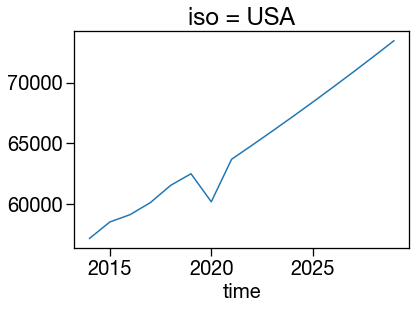

In [100]:
gpc.loc["USA",:].plot()

Assemble teleconnection data for the same time period

In [20]:
tc_metric = "t_p_corr_running"
tau = xr.DataArray(np.full((len(iso),len(time_ext)),np.nan),
                     coords=[iso,time_ext],dims=["iso","time"])
for i in tau.iso.values:
    tau.loc[i,:] = panel.loc[panel["iso"]==i,tc_metric+"_e"].values[0]

Now calculate marginal effects and growth changes due to the El Niño

In [21]:
me_nonlimited = coefs_enso_xr + coefs_int_xr*tau
# set marginal effects to zero for countries whose
# confidence intervals cross zero
me_lower = me_nonlimited.sum(dim="lag").quantile(0.025,dim="boot")
me_upper = me_nonlimited.sum(dim="lag").quantile(0.975,dim="boot")
me = me_nonlimited.where((me_lower<=0)&(me_upper<=0),0.0)

In [22]:
# useful functions
def create_growth_arrays(dg,iso,time,boot,forecast):
    cds = [forecast,boot,time,iso]
    dms = ["forecast","boot","time","iso"]
    cf_gdp = xr.DataArray(np.full(dg.values.shape,np.nan),
                         coords=cds,dims=dms)
    cf_growth = xr.DataArray(np.full(dg.values.shape,np.nan),
                         coords=cds,dims=dms)
    return([cf_gdp,cf_growth])

def calc_counterfactual_gdp(orig_growth,orig_gpc,delta_growth,iso,time,boot,forecast):
    cf_gpc, cf_growth = create_growth_arrays(delta_growth,iso,time,boot,forecast)
    cf_gr = orig_growth.loc[:,time].transpose("time","iso") + delta_growth
    cf_growth[:,:,:,:] = cf_gr.transpose("forecast","boot","time","iso").values
    for yy in np.arange(1,len(time),1):
        if yy == 1:
            cf_gdp_year = orig_gpc.loc[:,time[yy-1]]
        else:
            cf_gdp_year = cf_gpc.loc[:,:,time[yy-1],:]
        cf_gpc.loc[:,:,time[yy],:] = (cf_gdp_year+(cf_growth.loc[:,:,time[yy],:]*cf_gdp_year)).transpose("forecast","boot","iso")
    return([cf_gpc, cf_growth])

Actual and counterfactual Nino3.4

In [23]:
forecast_df = forecast.loc[:,["Model","DJF"]].dropna()
forecast_en = forecast_df.DJF.values
forecast_models = forecast_df.Model.values
actual_nino34 = xr.DataArray(np.zeros((len(forecast_en),len(time_ext))),
                                      coords=[forecast_models,time_ext],
                                      dims=["forecast","time"])
cf_nino34 = xr.DataArray(np.zeros((len(forecast_en),len(time_ext))),
                                      coords=[forecast_models,time_ext],
                                      dims=["forecast","time"])
actual_nino34.loc[:,2024] = forecast_en

In [102]:
me_initial = me.loc[:,0,:,:]
delta_growth = (me_initial*actual_nino34) - (me_initial*cf_nino34)
for l in np.arange(1,nlag+1,1):
    print(l)
    me_l = me.loc[:,l,:,:]
    delta = (me_l.shift(time=l)*actual_nino34.shift(time=l)) - (me_l.shift(time=l)*cf_nino34.shift(time=l))
    delta_growth = delta_growth + delta.where(~np.isnan(delta),0.0)

1
2
3
4
5


In [103]:
time_final = time_ext[1:]

In [104]:
cf_gpc, cf_gr = calc_counterfactual_gdp(gpc_growth.loc[:,time_final],gpc.loc[:,time_final],
                                     delta_growth.loc[:,:,time_final,:].transpose("forecast","boot","time","iso"),
                                     iso,time_final,boot,forecast_models)

In [105]:
gpc_change = cf_gpc - gpc
gdp_change = gpc_change*population

In [106]:
rate = 0.02
time_plot = np.arange(2024,2029+1,1)
dfact = xr.DataArray(np.exp(-1*rate*(time_plot-np.amin(time_plot)+1)),
                    coords=[time_plot],dims=["time"])

In [107]:
gdp_change_global = gdp_change.sum(dim="iso")
gdp_change_discounted = gdp_change_global.loc[:,:,time_plot]*dfact

Plot

BCC_CSM11m
CMC CANSIP
COLA CCSM4
GFDL SPEAR
IOCAS ICM
LDEO
NASA GMAO
NCEP CFSv2
SINTEX-F
BCC_RZDM
CPC CA
CPC MRKOV
CSU CLIPR
IAP-NN
UCLA-TCD
UW PSL-CSLIM
UW PSL-LIM
<xarray.DataArray (time: 6)>
array([-0.23690997, -0.48363284, -1.0043877 , -1.57552327, -2.41343501,
       -3.4765294 ])
Coordinates:
  * time     (time) int64 2024 2025 2026 2027 2028 2029


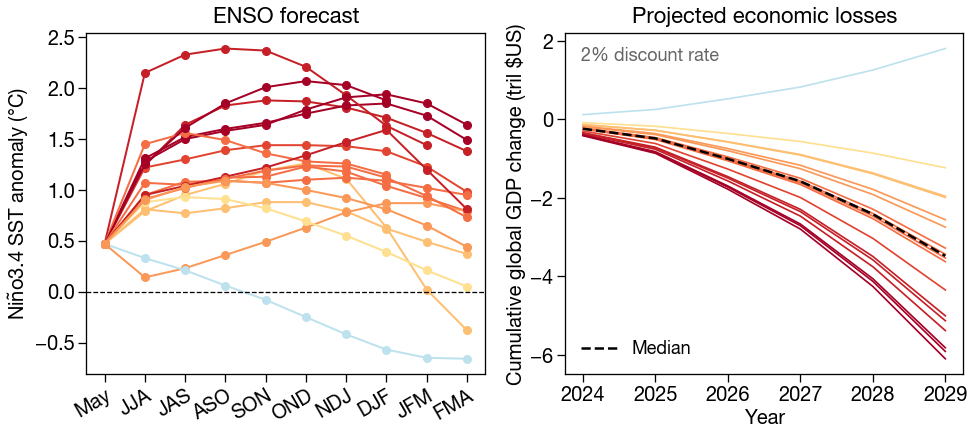

In [108]:
fig = plt.figure(figsize=(14,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"


gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.1,right=0.97,top=0.92,bottom=0.13,wspace=0.2,hspace=0.28)

tfs = 22
lfs = 18

## colorbar! for El Nino strength
cmin = -1.75
cmax = 1.75
nrange = 15
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

ax = plt.subplot(gs1[0,0])

col_dict = {}
for m in forecast_models:
    model_forecast = forecast.iloc[forecast.Model.values==m,2:].values[0] 
    #np.concatenate([[0],forecast.iloc[forecast.Model.values==m,2:].values[0]])
    col = cbar.to_rgba(model_forecast[-3])
    plt.plot(np.arange(0,len(model_forecast),1),model_forecast,
            color=col,marker="o",markersize=8,zorder=1,
            linewidth=2)
    col_dict[m] = col
    
#djf_vals = forecast.loc[:,"DJF"].values
#for x in djf_vals:
#    if ~np.isnan(x):
#        plt.scatter(9,x,color="red",s=100,zorder=2)
    
plt.title("ENSO forecast",fontsize=tfs,pad=10)
plt.ylabel("Ni$\~n$o3.4 SST anomaly ($\degree$C)")
plt.axhline(y=0,color="black",linewidth=1.3,linestyle="--")
months[0] = "May"
plt.xticks(ticks=np.arange(0,9+1,1),labels=months,
          rotation=30,rotation_mode="anchor",ha="right")


ax = plt.subplot(gs1[0,1])

for j in gdp_change_discounted.forecast.values:
    print(j)
    gdp_change_plot = np.cumsum(gdp_change_discounted.loc[j,:,time_plot].mean(dim="boot"))/1e12
    plt.plot(time_plot,gdp_change_plot,
            color=col_dict[j],linewidth=1.7)

median_proj = np.cumsum(gdp_change_discounted.loc[:,:,time_plot].median(dim=["forecast","boot"]))/1e12
plt.plot(time_plot,median_proj,color="black",linewidth=2.5,linestyle="--",label="Median")

print(median_proj)

plt.legend(loc="lower left",fontsize=18,frameon=False)
plt.title("Projected economic losses",fontsize=tfs,pad=10)
plt.xlabel("Year")
plt.ylabel("Cumulative global GDP change (tril $US)")
plt.text(0.04,0.92,str(int(rate*100))+"% discount rate",
         fontsize=18,transform=ax.transAxes,color=[0.4,0.4,0.4])

plt.savefig("../Figures/Projected_2024_Losses_06222023.pdf")
plt.show()

In [109]:
model_forecast

array([0.47, 0.9 , 1.03, 1.09, 1.07, 1.  , 0.92, 0.81, 0.65, 0.44])

In [110]:
proj = gdp_change_discounted.loc[:,:,time_plot].mean(dim=["boot"])/1e12
sum_proj = proj.sum(dim="time")

In [111]:
forecast_models

array(['BCC_CSM11m', 'CMC CANSIP', 'COLA CCSM4', 'GFDL SPEAR',
       'IOCAS ICM', 'LDEO', 'NASA GMAO', 'NCEP CFSv2', 'SINTEX-F',
       'BCC_RZDM', 'CPC CA', 'CPC MRKOV', 'CSU CLIPR', 'IAP-NN',
       'UCLA-TCD', 'UW PSL-CSLIM', 'UW PSL-LIM'], dtype=object)

In [112]:
len(model_forecast)

10

In [113]:
sum_proj[sum_proj==np.amax(sum_proj)]

<xarray.DataArray (forecast: 1)>
array([1.80483142])
Coordinates:
  * forecast  (forecast) object 'IAP-NN'

In [114]:
forecast_df_out = forecast.dropna() #.drop(columns="Type").reset_index().drop(columns="index")
gdp_change_discounted.name = "cumulative_global_gdp_loss"
gdp_change_df = np.cumsum(gdp_change_discounted.median(dim="boot")/1e12,axis=1).to_dataframe().reset_index()
forecast_df_out.to_csv(loc_summary+"ENSO_Forecast_June.csv")
gdp_change_df.to_csv(loc_summary+"Forecasted_Losses_June.csv")

Just for the US

In [115]:
gdp_change_usa = gdp_change.loc[:,:,:,"USA"] #.sum(dim="iso")
gdp_change_discounted_usa = gdp_change_usa.loc[:,:,time_plot]*dfact

<xarray.DataArray (time: 6)>
array([-0.04782933, -0.09209636, -0.18923564, -0.28980431, -0.44375911,
       -0.64184577])
Coordinates:
  * time     (time) int64 2024 2025 2026 2027 2028 2029
    iso      <U3 'USA'


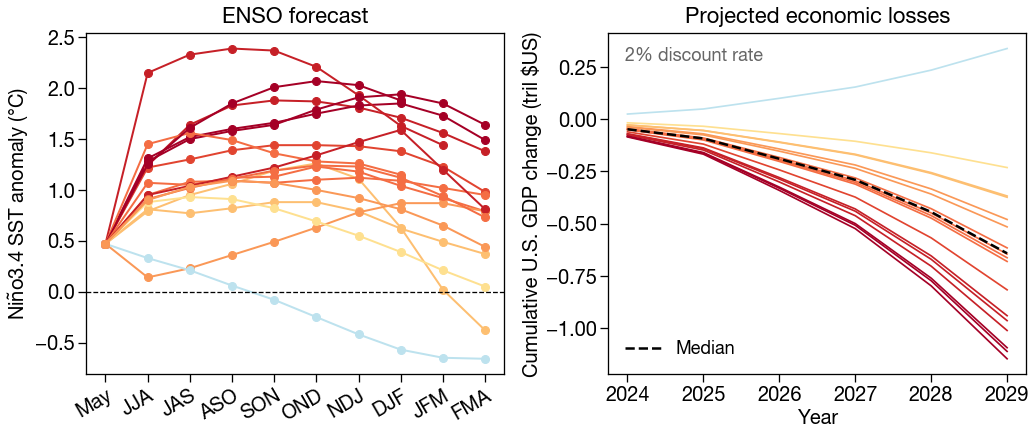

In [117]:
fig = plt.figure(figsize=(15,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"


gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.1,right=0.97,top=0.92,bottom=0.13,wspace=0.25,hspace=0.28)

tfs = 22
lfs = 18

## colorbar! for El Nino strength
cmin = -1.75
cmax = 1.75
nrange = 15
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

ax = plt.subplot(gs1[0,0])

col_dict = {}
for m in forecast_models:
    model_forecast = forecast.iloc[forecast.Model.values==m,2:].values[0] 
    #np.concatenate([[0],forecast.iloc[forecast.Model.values==m,2:].values[0]])
    col = cbar.to_rgba(model_forecast[-3])
    plt.plot(np.arange(0,len(model_forecast),1),model_forecast,
            color=col,marker="o",markersize=8,zorder=1,
            linewidth=2)
    col_dict[m] = col
    
#djf_vals = forecast.loc[:,"DJF"].values
#for x in djf_vals:
#    if ~np.isnan(x):
#        plt.scatter(9,x,color="red",s=100,zorder=2)
    
plt.title("ENSO forecast",fontsize=tfs,pad=10)
plt.ylabel("Ni$\~n$o3.4 SST anomaly ($\degree$C)")
plt.axhline(y=0,color="black",linewidth=1.3,linestyle="--")
months[0] = "May"
plt.xticks(ticks=np.arange(0,9+1,1),labels=months,
          rotation=30,rotation_mode="anchor",ha="right")


ax = plt.subplot(gs1[0,1])

for j in gdp_change_discounted_usa.forecast.values:
    #print(j)
    gdp_change_plot = np.cumsum(gdp_change_discounted_usa.loc[j,:,time_plot].mean(dim="boot"))/1e12
    plt.plot(time_plot,gdp_change_plot,
            color=col_dict[j],linewidth=1.7)

median_proj = np.cumsum(gdp_change_discounted_usa.loc[:,:,time_plot].median(dim=["forecast","boot"]))/1e12
plt.plot(time_plot,median_proj,color="black",linewidth=2.5,linestyle="--",label="Median")

print(median_proj)

plt.legend(loc="lower left",fontsize=18,frameon=False)
plt.title("Projected economic losses",fontsize=tfs,pad=10)
plt.xlabel("Year")
plt.ylabel("Cumulative U.S. GDP change (tril $US)")
plt.text(0.04,0.92,str(int(rate*100))+"% discount rate",
         fontsize=18,transform=ax.transAxes,color=[0.4,0.4,0.4])

plt.savefig("../Figures/Projected_2024_Losses_USA.pdf")
plt.show()

In [118]:
forecast_df_out = forecast.dropna() #.drop(columns="Type").reset_index().drop(columns="index")
gdp_change_discounted_usa.name = "cumulative_gdp_loss_trillions"
gdp_change_df = np.cumsum(gdp_change_discounted_usa.median(dim="boot")/1e12,axis=1).to_dataframe().reset_index()
forecast_df_out.to_csv(loc_summary+"ENSO_Forecast_June.csv")
gdp_change_df.to_csv(loc_summary+"Forecasted_US_Losses_June.csv")